In [1]:
import io
import zipfile
import pandas
from plotnine import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(archive.read(csv_name)))
    df.columns = df.columns.str.strip()
    return df

archive = 'grenoble_2018-10-02_1810915.zip'

/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/tom/.local/share/virtualenvs/mpi_calibration-tfxxshdH/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
read_csv(archive, 'results.csv')

,mem_align,rfact,time,bcast,matrix_size,gflops,proc_q,pfact,residual,thread_per_process,block_size,proc_p,swap,depth,process_per_node
0,8,2,212.19,2,65536,884.4,8,1,0.001254,1,128,4,0,1,32


In [3]:
read_csv('grenoble_2018-09-18_1809599.zip', 'results.csv')  # our previous experiment

,pfact,time,rfact,depth,thread_per_process,process_per_node,proc_p,proc_q,mem_align,matrix_size,block_size,bcast,swap,gflops,residual
0,1,232.63,2,1,1,32,4,8,8,65536,128,2,0,806.7,0.001254


In [4]:
read_csv('grenoble_2018-10-02_1810916.zip', 'results.csv')  # another experiment from today, without trace

,gflops,pfact,swap,proc_p,residual,block_size,thread_per_process,bcast,proc_q,process_per_node,depth,matrix_size,rfact,time,mem_align
0,884.0,1,0,4,0.001254,128,1,2,8,32,1,65536,2,212.28,8


Ok, so the performance of HPL is significantly different between the two experiments. I got 806.7 Gflops two weeks ago, 884.4 Gflops today.

In [5]:
df_blas = read_csv(archive, 'trace_blas_0.csv')
df_blas.columns = df_blas.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
df_blas.head()

,function,file,line,rank,m,n,k,lead_a,lead_b,lead_c,duration,timestamp
0,dtrsm,../HPL_pdrpanrlT.c,172,0,2,2,-1,128,128,-1,0.000042,-0.000043
1,dgemm,../HPL_pdrpanrlT.c,224,0,16382,2,2,16392,128,16392,0.000082,0.000011
2,dtrsm,../HPL_pdrpanrlT.c,172,0,0,2,-1,128,128,-1,0.000000,0.000201
3,dgemm,../HPL_pdrpanrlT.c,224,0,16380,0,2,16392,128,16392,0.000000,0.000204
4,dtrsm,../HPL_pdrpanrlT.c,172,0,4,4,-1,128,128,-1,0.000001,0.000207


In [6]:
print(len(df_blas))
df_blas = df_blas[df_blas.duration > 1e-4]
print(len(df_blas))

1791620
156598


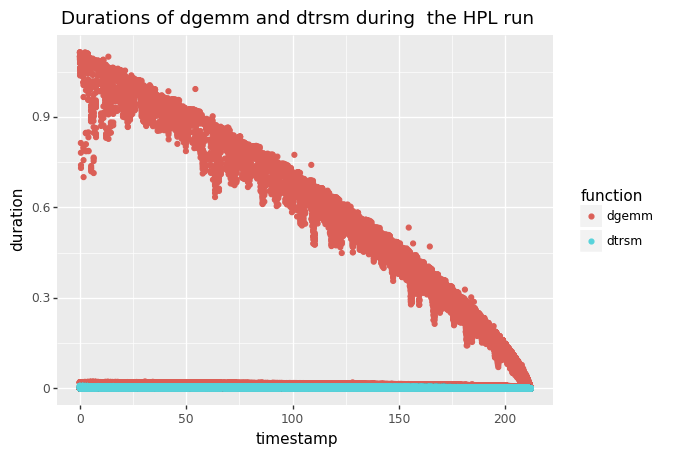

<ggplot: (8727410356502)>

In [7]:
ggplot(df_blas, aes(x='timestamp', y='duration', color='function')) + geom_point() + ggtitle('Durations of dgemm and dtrsm during  the HPL run')

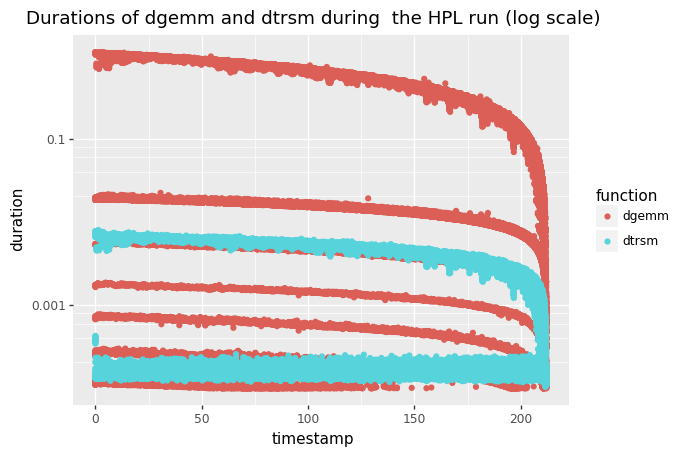

<ggplot: (-9223363309446137789)>

In [8]:
ggplot(df_blas, aes(x='timestamp', y='duration', color='function')) + geom_point() + scale_y_log10() + ggtitle('Durations of dgemm and dtrsm during  the HPL run (log scale)')

In [9]:
df_blas.m = df_blas.m.astype(float)
df_blas.n = df_blas.n.astype(float)
df_blas.k = df_blas.k.astype(float)
df_blas['mnk'] = df_blas.m * df_blas.n * df_blas.k
df_blas['mn2'] = df_blas.m * df_blas.n**2
df_blas['m2n'] = df_blas.m**2 * df_blas.n
df_dgemm = df_blas[df_blas.function == 'dgemm']
df_dtrsm = df_blas[df_blas.function == 'dtrsm']

In [10]:
SMPI_DGEMM_COEFFICIENT=6.576114746760746e-11
SMPI_DGEMM_INTERCEPT=1e-7
SMPI_DTRSM_COEFFICIENT=3.4419129894561347e-11
SMPI_DTRSM_INTERCEPT=1e-7

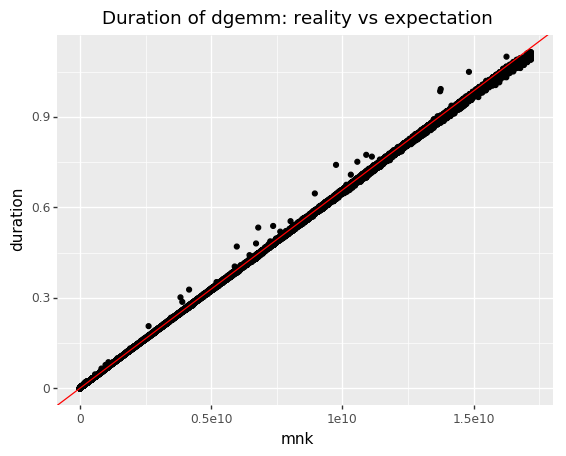

<ggplot: (-9223363309444989980)>

In [11]:
ggplot(df_dgemm, aes(x='mnk', y='duration')) + geom_point() + geom_abline(slope=SMPI_DGEMM_COEFFICIENT, intercept=SMPI_DGEMM_INTERCEPT, color='red') + ggtitle('Duration of dgemm: reality vs expectation')

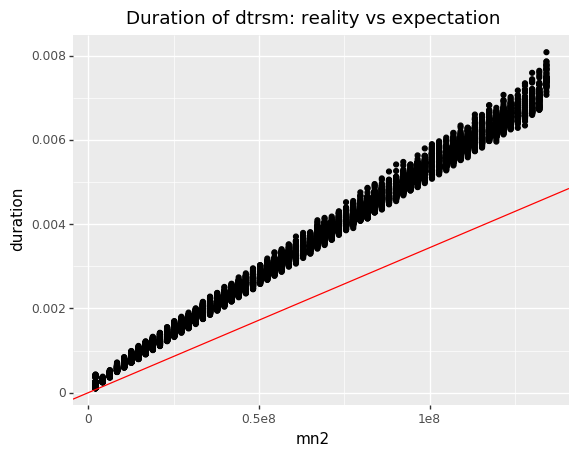

<ggplot: (8727409783542)>

In [12]:
ggplot(df_dtrsm, aes(x='mn2', y='duration')) + geom_point() + geom_abline(slope=SMPI_DTRSM_COEFFICIENT, intercept=SMPI_DTRSM_INTERCEPT, color='red') + ggtitle('Duration of dtrsm: reality vs expectation')

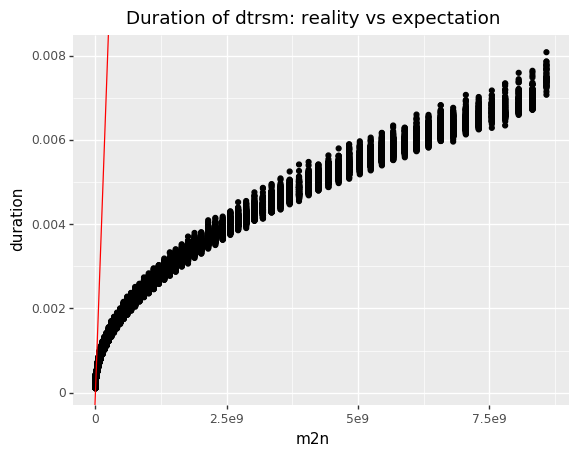

<ggplot: (8727409785699)>

In [13]:
ggplot(df_dtrsm, aes(x='m2n', y='duration')) + geom_point() + geom_abline(slope=SMPI_DTRSM_COEFFICIENT, intercept=SMPI_DTRSM_INTERCEPT, color='red') + ggtitle('Duration of dtrsm: reality vs expectation')